In [1]:
import numpy as np # A package for scientific computing in Python, providing support for arrays and matrices, as well as a wide range of mathematical operations
import pandas as pd # A library for data manipulation and analysis, providing data structures like DataFrames and Series to work with tabular data.
import seaborn as sns # A data visualization library based on Matplotlib that provides a high-level interface for creating informative and attractive statistical graphics.
import matplotlib.pyplot as plt # A plotting library for creating static, interactive, and animated visualizations in Python.
import plotly.graph_objects as go # A package for creating interactive and dynamic visualizations in Python, including graphs, charts, and maps.
# import scikitplot as sklpt
import kaleido # A package for exporting static images of visualizations created with Plotly or Matplotlib.
import warnings # A library for handling warnings and exceptions in Python.
warnings.filterwarnings("ignore")


from IPython.display import display # A module that provides functions for displaying various types of data within the IPython environment.
from matplotlib import colormaps # A module that provides a collection of color maps for use in visualizations.
from plotly.subplots import make_subplots

# scipy: A library for scientific computing and statistics in Python, including tools for optimization, integration, interpolation, and more.
import scipy.stats as sts
from scipy.stats import spearmanr, chi2_contingency, kendalltau
from scipy.stats import normaltest, ttest_ind
from scipy.stats import shapiro

# sklearn: A package that provides a wide range of machine learning algorithms and tools for data preprocessing, model selection, evaluation, and more.
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix


from itertools import combinations

# Data preparation

In [2]:
data = pd.read_csv("../data/healthcare-dataset-stroke-data.csv", index_col=0 #sets the first column of the CSV file as the index of the dataframe 
                   , dtype = {
        'id' : int,
        'gender' : 'category', # pd.CategoricalDtype(categories=["Male", "Female"], ordered=False),
        'age' : float,
        'hypertension' : bool,
        'heart_disease' : bool,
        'ever_married' : 'category',
        'work_type' : 'category', # pd.CategoricalDtype(categories=["Private", "Self-employed", "Govt_job"], ordered=False),
        'Residence_type' : 'category', # pd.CategoricalDtype(categories=["Urban", "Rural"], ordered=False),
        'avg_glucose_level' : float,
        'bmi' : float,
        'smoking_status' : 'category', # pd.CategoricalDtype(categories=["never smoked", "smokes", "formerly smoked", "Unknown"], ordered=False),
        'stroke' : bool
    },
)

## Data exploration

In [3]:
#identify features
num_cols = ["age", "avg_glucose_level", "bmi"]
cate_cols = ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status"]
data[cate_cols] = data[cate_cols].astype('category')

In [4]:
print(data.dtypes)
print("-"*100)
print('shape:', data.shape)
print("-"*100)
print(data.head(10))
print("-"*100)
print('missing values: ', data.isna().sum())
print("-"*100)
print(data.describe())
print("-"*100)

gender               category
age                   float64
hypertension         category
heart_disease        category
ever_married         category
work_type            category
Residence_type       category
avg_glucose_level     float64
bmi                   float64
smoking_status       category
stroke                   bool
dtype: object
----------------------------------------------------------------------------------------------------
shape: (5110, 11)
----------------------------------------------------------------------------------------------------
       gender   age hypertension heart_disease ever_married      work_type  \
id                                                                           
9046     Male  67.0        False          True          Yes        Private   
51676  Female  61.0        False         False          Yes  Self-employed   
31112    Male  80.0        False          True          Yes        Private   
60182  Female  49.0        False         False

### Balance

checking if the data is balanced or not

In [5]:
#how many strokes
print(data["stroke"].value_counts())
print("-"*100)

False    4861
True      249
Name: stroke, dtype: int64
----------------------------------------------------------------------------------------------------


In [6]:
# check for missing values within the data stroke = True
filtered_data = data[(data['stroke'] == True) & (data['bmi'].isna())]
count = len(filtered_data)
print("Sum of values with stroke=True and BMI= N/A:", count)
percentage = (count / data[data["stroke"] == True]["stroke"].value_counts().loc[True]) * 100
print('This accounts for', round(percentage,2), '% of stroke = True data')

Sum of values with stroke=True and BMI= N/A: 40
This accounts for 16.06 % of stroke = True data


#### This shows that we have about 16% missing values within the True values for stroke. Since we already have very imbalanced data, it is not very useful to further delete data with missing values. Therefore we decided to replace the missing values.


The Data is imbalanced! -> challenges for certain machine learning algorithms, as the model may be biased towards the majority class and struggle to learn patterns from the minority class.

This means we have to perform a stratified K-Fold when splitting the Data into Test- and Training-Data

## Data Cleaning

handling missing values, outliers, and other inconsistencies in the data

### Categorical Data

In [7]:
#unique values as overview
category_columns = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']

for column in category_columns:
    unique_categories = data[column].unique()
    print(f"Unique categories in {column}: {unique_categories}")

Unique categories in gender: ['Male', 'Female', 'Other']
Categories (3, object): ['Female', 'Male', 'Other']
Unique categories in hypertension: [False, True]
Categories (2, bool): [False, True]
Unique categories in heart_disease: [True, False]
Categories (2, bool): [False, True]
Unique categories in ever_married: ['Yes', 'No']
Categories (2, object): ['No', 'Yes']
Unique categories in work_type: ['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked']
Categories (5, object): ['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children']
Unique categories in Residence_type: ['Urban', 'Rural']
Categories (2, object): ['Rural', 'Urban']
Unique categories in smoking_status: ['formerly smoked', 'never smoked', 'smokes', 'Unknown']
Categories (4, object): ['Unknown', 'formerly smoked', 'never smoked', 'smokes']
Unique categories in stroke: [ True False]


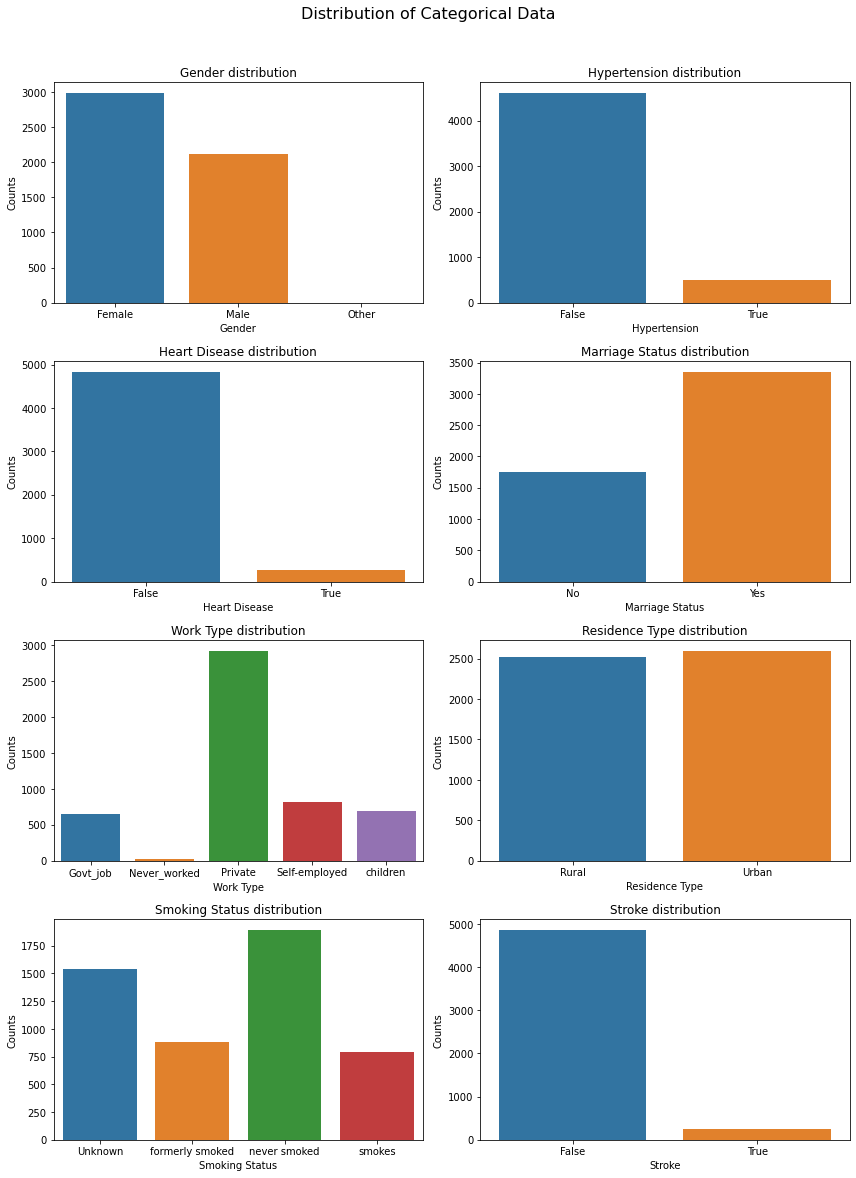

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 16))

sns.countplot(data=data, x='gender', ax=axes[0, 0])
axes[0, 0].set(xlabel='Gender', ylabel='Counts', title='Gender distribution')

sns.countplot(data=data, x='hypertension', ax=axes[0, 1])
axes[0, 1].set(xlabel='Hypertension', ylabel='Counts', title='Hypertension distribution')

sns.countplot(data=data, x='heart_disease', ax=axes[1, 0])
axes[1, 0].set(xlabel='Heart Disease', ylabel='Counts', title='Heart Disease distribution')

sns.countplot(data=data, x='ever_married', ax=axes[1, 1])
axes[1, 1].set(xlabel='Marriage Status', ylabel='Counts', title='Marriage Status distribution')

sns.countplot(data=data, x='work_type', ax=axes[2, 0])
axes[2, 0].set(xlabel='Work Type', ylabel='Counts', title='Work Type distribution')

sns.countplot(data=data, x='Residence_type', ax=axes[2, 1])
axes[2, 1].set(xlabel='Residence Type', ylabel='Counts', title='Residence Type distribution')

sns.countplot(data=data, x='smoking_status', ax=axes[3, 0])
axes[3, 0].set(xlabel='Smoking Status', ylabel='Counts', title='Smoking Status distribution')

sns.countplot(data=data, x='stroke', ax=axes[3, 1])
axes[3, 1].set(xlabel='Stroke', ylabel='Counts', title='Stroke distribution')

plt.suptitle('Distribution of Categorical Data', fontsize=16, y=1.02)

plt.tight_layout()
plt.savefig('..\output\distribution_categorical.jpg', bbox_inches='tight')  # Save the figure with tight bounding box
plt.show()


In [9]:
# gender
print(data['gender'].value_counts())
print("-"*100)

# hypertension
print(data['hypertension'].value_counts())
print("-"*100)

# heart_disease
print(data['heart_disease'].value_counts())
print("-"*100)

# ever_married
print(data['ever_married'].value_counts())
print("-"*100)

# work_type
print(data['work_type'].value_counts())
print("-"*100)

# Residence_type
print(data['Residence_type'].value_counts())
print("-"*100)

# smoking_status
print(data['smoking_status'].value_counts())
print("-"*100)


Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
----------------------------------------------------------------------------------------------------
False    4612
True      498
Name: hypertension, dtype: int64
----------------------------------------------------------------------------------------------------
False    4834
True      276
Name: heart_disease, dtype: int64
----------------------------------------------------------------------------------------------------
Yes    3353
No     1757
Name: ever_married, dtype: int64
----------------------------------------------------------------------------------------------------
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
----------------------------------------------------------------------------------------------------
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
----------------------------------------

#### Cleaning the Categorical Data

In [10]:
#gender distribution has only one in the category 'other' so we can delete this category
print("Shape before cleaning 'gender'", data.shape)
other_count = data['gender'].value_counts()['Other']
print("Count of 'Other' in the 'gender' column:", other_count)
other_indices = data[data['gender'] == 'Other'].index.tolist()
print("Indices where 'Other' occurs in the 'gender' column:", other_indices)
data = data.drop(other_indices, axis=0)
data["gender"] = data["gender"].cat.remove_categories("Other")
print("-"*100)
print(data['gender'].value_counts())
print("Shape after cleaning 'gender'", data.shape)


Shape before cleaning 'gender' (5110, 11)
Count of 'Other' in the 'gender' column: 1
Indices where 'Other' occurs in the 'gender' column: [56156]
----------------------------------------------------------------------------------------------------
Female    2994
Male      2115
Name: gender, dtype: int64
Shape after cleaning 'gender' (5109, 11)


### Continuous Data

In [11]:
# age
print('min age: ', data['age'].min())
print('max age: ', data['age'].max())
print('mean age: ', data['age'].mean())
print('median age: ', data['age'].median())
print("-"*100)

# avg_glucose_level
print('min avg_glucose_level: ', data['avg_glucose_level'].min())
print('max avg_glucose_level: ', data['avg_glucose_level'].max())
print('mean avg_glucose_level: ', data['avg_glucose_level'].mean())
print('median avg_glucose_level: ', data['avg_glucose_level'].median())
print("-"*100)

# bmi
print('min bmi: ', data['bmi'].min())
print('max bmi: ', data['bmi'].max())
print('mean bmi: ', data['bmi'].mean())
print('median bmi: ', data['bmi'].median())
print("-"*100)

min age:  0.08
max age:  82.0
mean age:  43.22998629868859
median age:  45.0
----------------------------------------------------------------------------------------------------
min avg_glucose_level:  55.12
max avg_glucose_level:  271.74
mean avg_glucose_level:  106.14039929536114
median avg_glucose_level:  91.88
----------------------------------------------------------------------------------------------------
min bmi:  10.3
max bmi:  97.6
mean bmi:  28.894559902200488
median bmi:  28.1
----------------------------------------------------------------------------------------------------


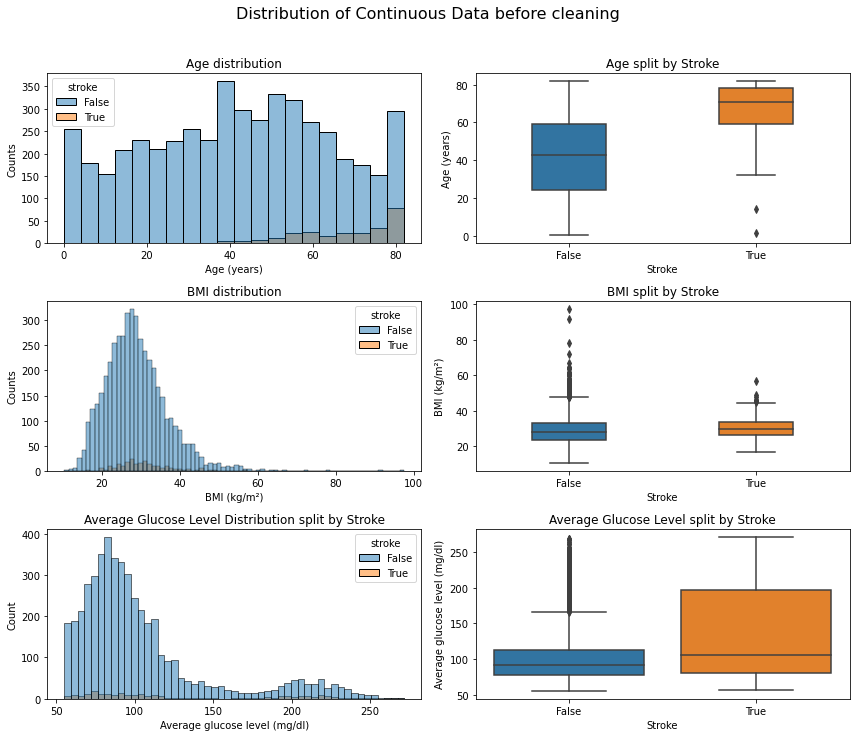

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

# Age distribution
sns.histplot(data=data, x='age', hue='stroke', ax=axes[0, 0])
axes[0, 0].set(xlabel='Age (years)', ylabel='Counts', title='Age distribution')

# Age split by Stroke
sns.boxplot(data=data, x='stroke', y='age', width=0.4, ax=axes[0, 1])
axes[0, 1].set(xlabel='Stroke', ylabel='Age (years)', title='Age split by Stroke')

# BMI distribution
sns.histplot(data=data, x='bmi', hue='stroke', ax=axes[1, 0])
axes[1, 0].set(xlabel='BMI (kg/m²)', ylabel='Counts', title='BMI distribution')

# BMI split by Stroke
sns.boxplot(data=data, x='stroke', y='bmi', width=0.4, ax=axes[1, 1])
axes[1, 1].set(xlabel='Stroke', ylabel='BMI (kg/m²)', title='BMI split by Stroke')

# Glucose Level distribution
sns.histplot(data, x = 'avg_glucose_level', hue = 'stroke', ax=axes[2, 0])
axes[2, 0].set(xlabel = 'Average glucose level (mg/dl)', ylabel = 'Count', title = 'Average Glucose Level Distribution split by Stroke')

# Glucose Level split by Stroke
sns.boxplot(data, x = 'stroke', y ='avg_glucose_level', ax=axes[2, 1])
axes[2, 1].set(xlabel = 'Stroke', ylabel = 'Average glucose level (mg/dl)', title = 'Average Glucose Level split by Stroke')


plt.suptitle('Distribution of Continuous Data before cleaning', fontsize=16, y=1.02)

plt.tight_layout()
plt.savefig('..\output\distribution_continuous_before.jpg', bbox_inches='tight')  # Save the figure with tight bounding box
plt.show()

#### Cleaning the Continuous Data

All the NaN Values of the Dataset are in the column 'BMI'
Since there are a lot of missing BMI values within the Stroke = True Data, we cannot just delet all these values. 
The missing values need to be adapted!!!

We want to predict the BMI values and for that this step will happen after encoding the data.

First we will take care of Outliers

### Missing BMI values problem

In [13]:
# Since there are a lot of missing BMI values within the Stroke = True Data, we cannot just delet all these values. 
# The missing values need to be adapted!!!

print(data.shape)
#data.dropna(axis='index', subset=['bmi'], inplace=True) #this command would delete missing values, what we don't want
#data['bmi'] = data['bmi'].fillna(data['bmi'].mean()) #this would fill the missing values with means

# BMI Prediction after scaling and encoding
print(data.shape)
# data.isna().sum()
#axis='index' -> rows containing missing values in the specified subset should be dropped
#inplace=True-> changes are made directly to the data DataFrame.

(5109, 11)
(5109, 11)


analyzing boxplots-> not only impossible values but also max/mins because not representative for population


In [14]:
#bmi: highest measured are around 200 so 100 is possible
print(data.shape)
print("-"*100)
filtered_data_bmi_f = data[(data['stroke'] == False) & (data['bmi'] >70)]
#print(filtered_data_bmi_f)
filtered_ids_bmi_f = filtered_data_bmi_f.index.tolist()
print("IDs that satisfy the bmi criteria without stroke:", filtered_ids_bmi_f)
data = data.drop(filtered_ids_bmi_f, axis=0)
print("-"*100)
print(data.shape)

filtered_data_bmi_t = data[(data['stroke'] == True) & (data['bmi'] >50)]
#print(filtered_data_bmi_t)
filtered_ids_bmi_t = filtered_data_bmi_t.index.tolist()
print("IDs that satisfy the bmi criteria with stroke:", filtered_ids_bmi_t)
data = data.drop(filtered_ids_bmi_t, axis=0)
print("-"*100)

#avg_glucose_level-> looks right/positive skewed, continuous values to the right-> no outliers detectable

#age: 2 outliers in the group stroke = True
print(data.shape)
print("-"*100)
filtered_data_age = data[(data['stroke'] == True) & (data['age'] < 30)]
#print(filtered_data_age)
#print('----------------------')
#num_ids = len(filtered_data)
#print(f"Number of IDs: {num_ids}")
#print('----------------------')
filtered_ids_age = filtered_data_age.index.tolist()
print("IDs that satisfy the age criteria:", filtered_ids_age)
data = data.drop(filtered_ids_age, axis=0)
print(data.shape)

(5109, 11)
----------------------------------------------------------------------------------------------------
IDs that satisfy the bmi criteria without stroke: [545, 41097, 56420, 51856]
----------------------------------------------------------------------------------------------------
(5105, 11)
IDs that satisfy the bmi criteria with stroke: [41069]
----------------------------------------------------------------------------------------------------
(5104, 11)
----------------------------------------------------------------------------------------------------
IDs that satisfy the age criteria: [69768, 49669]
(5102, 11)


do the bar plot again to see if outliers are gone

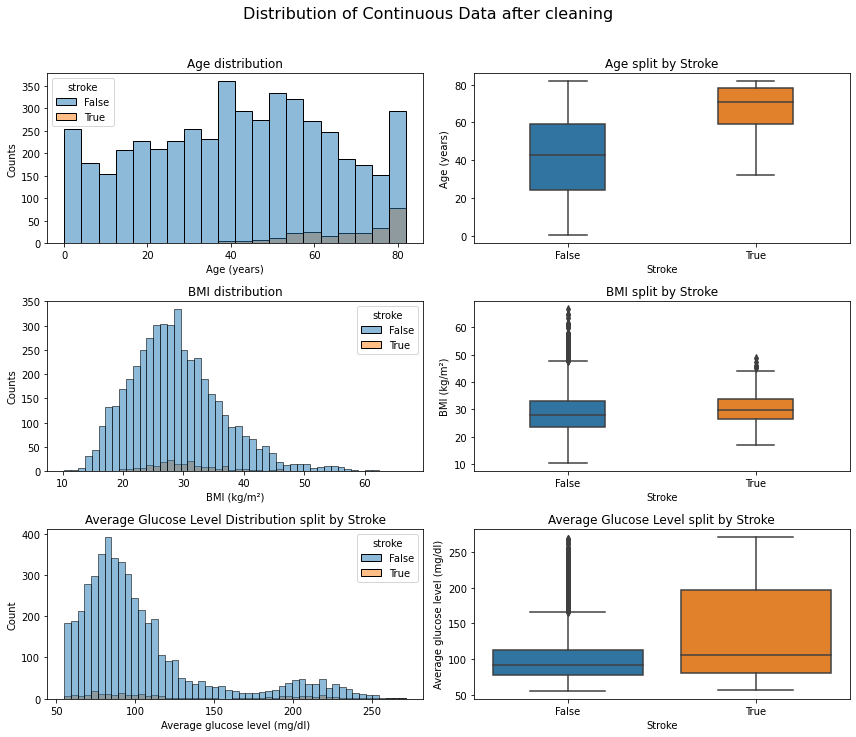

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

# Age distribution
sns.histplot(data=data, x='age', hue='stroke', ax=axes[0, 0])
axes[0, 0].set(xlabel='Age (years)', ylabel='Counts', title='Age distribution')

# Age split by Stroke
sns.boxplot(data=data, x='stroke', y='age', width=0.4, ax=axes[0, 1])
axes[0, 1].set(xlabel='Stroke', ylabel='Age (years)', title='Age split by Stroke')

# BMI distribution
sns.histplot(data=data, x='bmi', hue='stroke', ax=axes[1, 0])
axes[1, 0].set(xlabel='BMI (kg/m²)', ylabel='Counts', title='BMI distribution')

# BMI split by Stroke
sns.boxplot(data=data, x='stroke', y='bmi', width=0.4, ax=axes[1, 1])
axes[1, 1].set(xlabel='Stroke', ylabel='BMI (kg/m²)', title='BMI split by Stroke')

# Glucose Level distribution
sns.histplot(data, x = 'avg_glucose_level', hue = 'stroke', ax=axes[2, 0])
axes[2, 0].set(xlabel = 'Average glucose level (mg/dl)', ylabel = 'Count', title = 'Average Glucose Level Distribution split by Stroke')

# Glucose Level split by Stroke
sns.boxplot(data, x = 'stroke', y ='avg_glucose_level', ax=axes[2, 1])
axes[2, 1].set(xlabel = 'Stroke', ylabel = 'Average glucose level (mg/dl)', title = 'Average Glucose Level split by Stroke')


plt.suptitle('Distribution of Continuous Data after cleaning', fontsize=16, y=1.02)

plt.tight_layout()
plt.savefig('..\output\distribution_continuous_after.jpg', bbox_inches='tight')  # Save the figure with tight bounding box
plt.show()

## Scaling

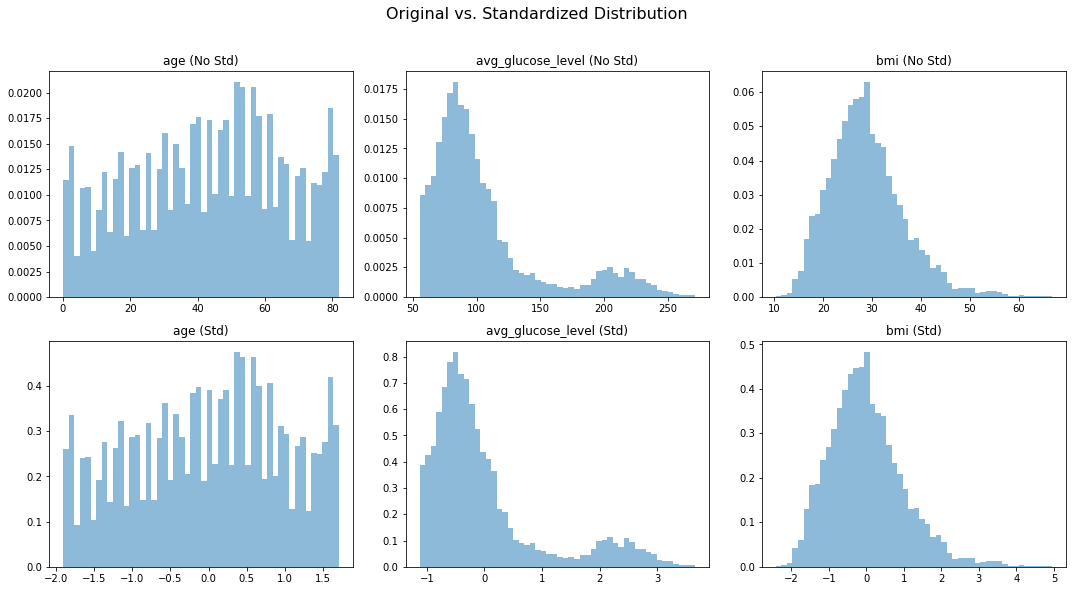

In [16]:
#standard scaler
sc = StandardScaler()

data_scaled = data.copy()

data_scaled[num_cols] = sc.fit_transform(data[num_cols])


# compare the three features before and after standardization
first_3_features = data[num_cols].iloc[:, :3].values
first_3_features_scaled = data_scaled[num_cols].iloc[:, :3].values
first_3_feature_names = num_cols[:3]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, feature_name in enumerate(first_3_feature_names):
    # Without standardization
    axes[0, i].hist(first_3_features[:, i], bins=50, density=True, alpha=0.5)
    axes[0, i].set_title("{} (No Std)".format(feature_name))

    # With standardization
    axes[1, i].hist(first_3_features_scaled[:, i], bins=50, density=True, alpha=0.5)
    axes[1, i].set_title("{} (Std)".format(feature_name))

plt.suptitle('Original vs. Standardized Distribution', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

## One-Hot Encoding

One-hot encoding is used to convert categorical variables with multiple categories into binary vectors. Each category is represented by a binary column, where a value of 1 indicates the presence of the category and 0 represents the absence. One-hot encoding is suitable when there is no inherent ordinal relationship between the categories.

In [17]:
#Perform one-hot encoding on the categorical features
#One-hot encoding creates a new binary (0/1) column for each unique value in the categorical feature
df = pd.DataFrame(data)
print("Original dataset:")
display(df)

# One-hot encodeing of just the feature stroke:  
#encoded_df = pd.get_dummies(df, columns=['stroke'], prefix='stroke', drop_first=True)
#print("\nDataset with one-hot encoding of stroke:")
#display(encoded_df)

encoded_df = pd.get_dummies(data, columns=cate_cols, prefix = cate_cols, drop_first= True)
print("\nDataset with one-hot encoding:")
display(encoded_df)

Original dataset:


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,False,True,Yes,Private,Urban,228.69,36.6,formerly smoked,True
51676,Female,61.0,False,False,Yes,Self-employed,Rural,202.21,NaN,never smoked,True
31112,Male,80.0,False,True,Yes,Private,Rural,105.92,32.5,never smoked,True
60182,Female,49.0,False,False,Yes,Private,Urban,171.23,34.4,smokes,True
1665,Female,79.0,True,False,Yes,Self-employed,Rural,174.12,24.0,never smoked,True
...,...,...,...,...,...,...,...,...,...,...,...
18234,Female,80.0,True,False,Yes,Private,Urban,83.75,NaN,never smoked,False
44873,Female,81.0,False,False,Yes,Self-employed,Urban,125.20,40.0,never smoked,False
19723,Female,35.0,False,False,Yes,Self-employed,Rural,82.99,30.6,never smoked,False



Dataset with one-hot encoding:


,age,avg_glucose_level,bmi,stroke,gender_Male,hypertension_True,heart_disease_True,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
id,,,,,,,,,,,,,,,,
9046,67.0,228.69,36.6,True,1,0,1,1,0,1,0,0,1,1,0,0
51676,61.0,202.21,NaN,True,0,0,0,1,0,0,1,0,0,0,1,0
31112,80.0,105.92,32.5,True,1,0,1,1,0,1,0,0,0,0,1,0
60182,49.0,171.23,34.4,True,0,0,0,1,0,1,0,0,1,0,0,1
1665,79.0,174.12,24.0,True,0,1,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18234,80.0,83.75,NaN,False,0,1,0,1,0,1,0,0,1,0,1,0
44873,81.0,125.20,40.0,False,0,0,0,1,0,0,1,0,1,0,1,0
19723,35.0,82.99,30.6,False,0,0,0,1,0,0,1,0,0,0,1,0


### BMI missing values prediction

In [18]:
# BMI Problem Prediction
# Split data into training and prediction sets
training_data = encoded_df[~encoded_df['bmi'].isna()]  # Rows with known BMI values
prediction_data = encoded_df[encoded_df['bmi'].isna()]  # Rows with NaN BMI values


# Check if there are any rows with missing BMI values
if prediction_data.empty:
    print("No rows with missing BMI values found.")
else:
    # Prepare training set
    features = ['age', 'gender_Male', 'hypertension_True', 'heart_disease_True', 'avg_glucose_level']
    target = 'bmi'
    X_train = training_data[features]
    y_train = training_data[target]

    # Create and train DecisionTreeRegressor
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)

    # Predict BMI values for NaN entries in the prediction set
    X_pred = prediction_data[features]
    predicted_bmi = model.predict(X_pred)

    # Assign predicted BMI values to the corresponding rows in the original dataset
    encoded_df.loc[encoded_df['bmi'].isna(), 'bmi'] = predicted_bmi

#encoded_df.isna().sum()

# to fill the missing BMI values also within the data set for further plotting tasks
if data.loc[data['bmi'].isna()].shape[0] > 0:
    data.loc[data['bmi'].isna(), 'bmi'] = predicted_bmi
#data.isna().sum()

# BMI visualization
# print(predicted_bmi)

### Correlation Heatmap

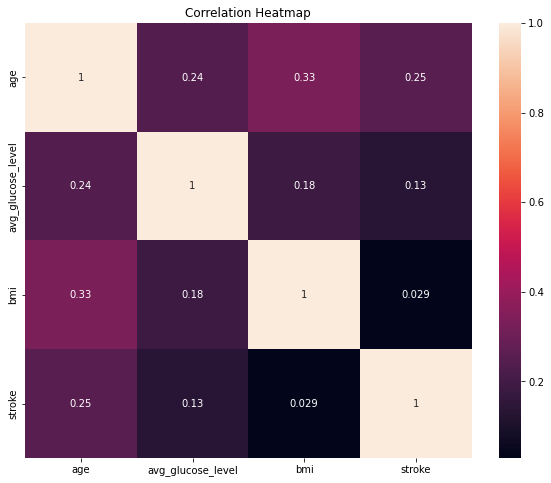

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(),annot=True)
plt.title("Correlation Heatmap")
plt.show()

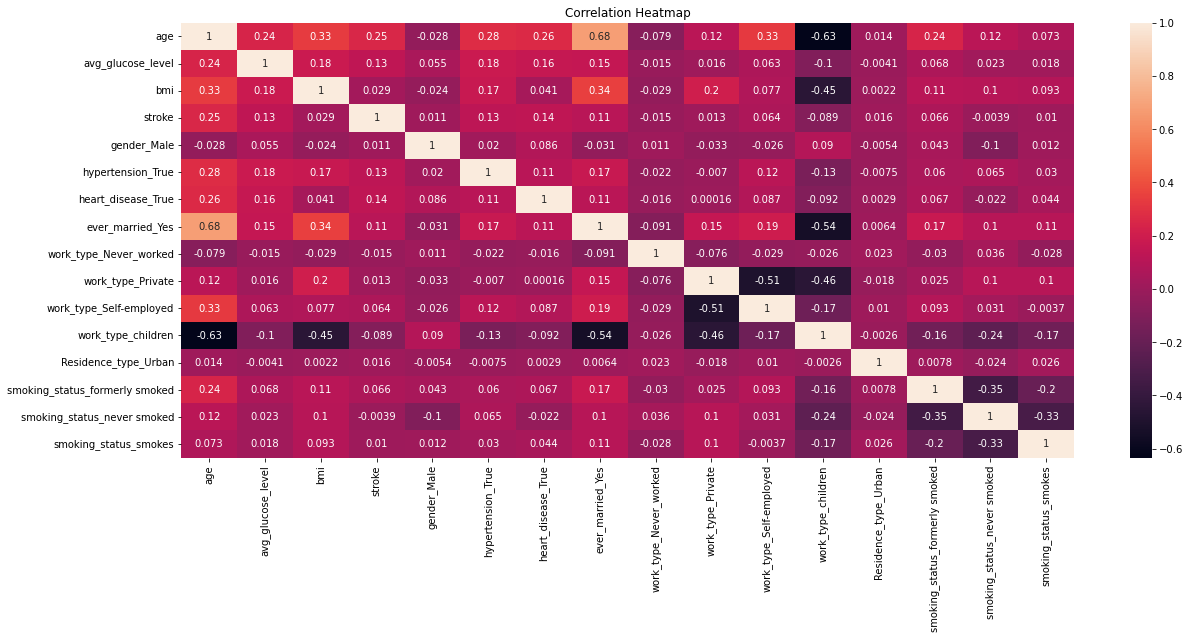

In [20]:
plt.figure(figsize=(20, 8))
sns.heatmap(encoded_df.corr(),annot=True)
plt.title("Correlation Heatmap")
plt.show()
#stroke in 4th line

## Feature selection

In [21]:
#Mutual information for FS for categorical output and categorical input
X = encoded_df.drop('stroke', axis=1)  # Features
y = encoded_df['stroke']  # Target variable (stroke)

selector_MI = SelectKBest(mutual_info_classif, k=5)
X_selected_MI = selector_MI.fit_transform(X,y)

selected_feature_indices_MI = selector_MI.get_support(indices=True)
selected_features_MI = X.columns[selected_feature_indices_MI]

print("Selected features MI: ", selected_features_MI)

Selected features MI:  Index(['age', 'avg_glucose_level', 'hypertension_True', 'ever_married_Yes',
       'work_type_children'],
      dtype='object')


In [22]:
#Chi squared for FS for categorical output and categorical input
X = encoded_df.drop('stroke', axis=1)  # Features
y = encoded_df['stroke']  # Target variable (stroke)

selector_Chi = SelectKBest(chi2, k=5)
X_selected_Chi = selector_Chi.fit_transform(X,y)

selected_feature_indices_Chi = selector_Chi.get_support(indices=True)
selected_features_Chi = X.columns[selected_feature_indices_Chi]

print("Selected features Chi squared: ", selected_features_Chi)

Selected features Chi squared:  Index(['age', 'avg_glucose_level', 'hypertension_True', 'heart_disease_True',
       'work_type_children'],
      dtype='object')


In [23]:
#ANOVA for FS for categorical output and numeric input
X = encoded_df.drop('stroke', axis=1)  # Features
y = encoded_df['stroke']  # Target variable (stroke)

selector_A = SelectKBest(f_classif, k=5)
X_selected_A = selector_A.fit_transform(X,y)

selected_feature_indices_A = selector_A.get_support(indices=True)
selected_features_A = X.columns[selected_feature_indices_A]

print("Selected features ANOVA: ", selected_features_A)

Selected features ANOVA:  Index(['age', 'avg_glucose_level', 'hypertension_True', 'heart_disease_True',
       'ever_married_Yes'],
      dtype='object')


In [24]:
#Kendall's rank  for FS for categorical output and numeric input
X = encoded_df.drop('stroke', axis=1)  # Features
y = encoded_df['stroke']  # Target variable (stroke)

correlation_scores=[]
for feature in X.columns:
    correlation, _ = kendalltau(X[feature],y)
    correlation_scores.append(correlation)

selector_K = SelectKBest(k=5)
X_selected_K = selector_K.fit_transform(X,y)

selected_feature_indices_K = selector_K.get_support(indices=True)
selected_features_K = X.columns[selected_feature_indices_K]

print("Selected features Kendall's: ", selected_features_K)

Selected features Kendall's:  Index(['age', 'avg_glucose_level', 'hypertension_True', 'heart_disease_True',
       'ever_married_Yes'],
      dtype='object')


##### Most important features: Age, Average Glucose Level, Hypertension, Heart Disease, Marriage, Work Type

In [25]:
# Combine selected features from both methods into a single list
selected_features = list(set(selected_features_K).union(selected_features_MI, selected_features_A, selected_features_Chi))
print("Combined selected features: ", selected_features)


Combined selected features:  ['work_type_children', 'age', 'avg_glucose_level', 'hypertension_True', 'ever_married_Yes', 'heart_disease_True']


## Test Split

In [26]:
X = encoded_df.drop('stroke', axis=1)  # Features
y = encoded_df['stroke']  # Target variable (stroke)

# Split the data into training and test sets - the training set will be used for the cross-validation, while the test set is reserved to perform the overall evaluation in the end
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(y_train.sum())
print(y_test.sum())

197
49


# Statistical Analysis

Conduct statistical analyses to quantify relationships, assess significance, and make inferences about the data. This may involve calculating summary statistics, performing hypothesis testing, conducting regression analyses, or applying other statistical techniques as relevant to the data and goals.

Check if continuous variables are normally distributed - looking at the hisplots in Tutorial 3

Perform Shapiro-Wilk test for normality: P value larger than 0.05 -> normal distribution is assumed!  

In [27]:
#Check if continuous variables are normally distributed
#looking at the hisplots in Tutorial 3
#Perform Shapiro-Wilk test for normality
#P value larger than 0.05 -> normal distribution is assumed!  
columns = data.select_dtypes(include=[np.number]).columns
for var in columns:
    result = sts.shapiro(data[var].dropna())
    print(f"Shapiro-Wilk for {var}, p-value: {result.pvalue:.10f}")
#they are all NOT normally distributed-> take that into account later with alternative statistical techniques or distributions

Shapiro-Wilk for age, p-value: 0.0000000000
Shapiro-Wilk for avg_glucose_level, p-value: 0.0000000000
Shapiro-Wilk for bmi, p-value: 0.0000000000


they are all NOT normally distributed-> take that into account later with alternative statistical techniques or distributions

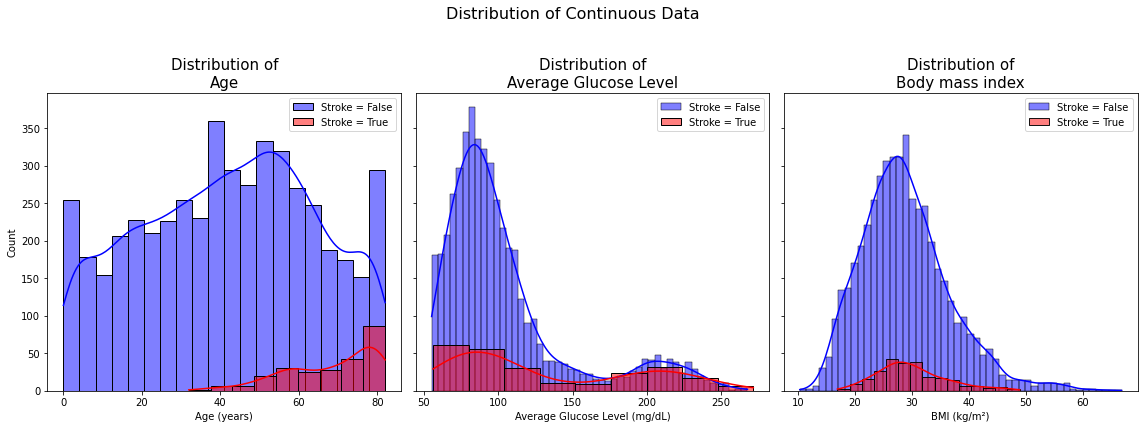

In [28]:
#plot the distributions of bmi, average glucose level and age
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()

fig, axs = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(16, 10))
titles = {
    "age": "Age",
    "bmi": "Body mass index",
    "avg_glucose_level": "Average Glucose Level",
}
xlabels = {
    "age": "Age (years)",
    "bmi": "BMI (kg/m²)",
    "avg_glucose_level": "Average Glucose Level (mg/dL)",
}

for i, ax in enumerate(axs.flatten()):
    if i < len(numeric_columns):
        column = numeric_columns[i]
        sns.histplot(data=data[data['stroke'] == False], x=column, kde=True, ax=ax, color='blue', label='Stroke = False')
        sns.histplot(data=data[data['stroke'] == True], x=column, kde=True, ax=ax, color='red', label='Stroke = True')
        ax.set_title(f"Distribution of\n{titles[column]}", fontsize=15)
        ax.set_xlabel(xlabels[column], fontsize=10)
        ax.legend()
        if i != 0 and i != 3:
            ax.set_ylabel(None)
    else:
        fig.delaxes(ax)

plt.suptitle('Distribution of Continuous Data', fontsize=16, y=1.02)

fig.tight_layout()
plt.savefig('..\output\distribution_continuous.jpg')
plt.show()


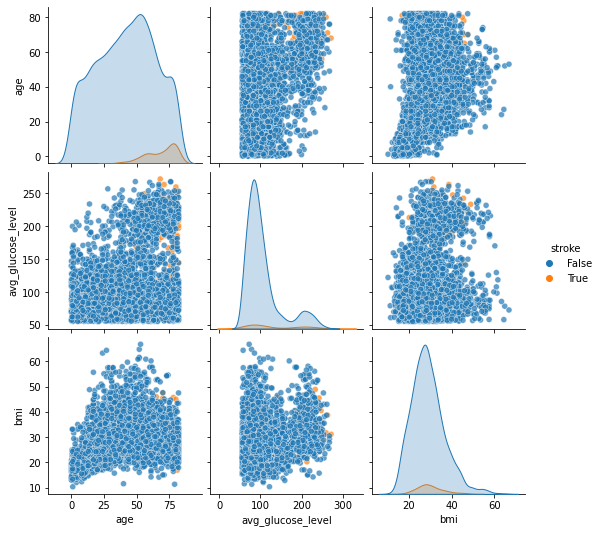

In [29]:
#correlation between variables
vars = data.select_dtypes(include=[np.number]).columns.tolist()
plot = sns.pairplot(data=data, vars=vars, hue="stroke", plot_kws={"alpha": 0.7, "marker": "o"})#plot_kws makes dots a little transparent
plot._legend.set_bbox_to_anchor((1, 0.5))  # Adjust legend position
plt.show()

In [30]:
#quantify correlation between variable pairs
for comb in combinations(vars, 2):
    print(f" {comb[0]} - {comb[1]}")
    spearman_result = sts.spearmanr(data[comb[0]], data[comb[1]])
    spearman_correlation = spearman_result.correlation
    spearman_pvalue = spearman_result.pvalue
    pearson_result = sts.pearsonr(data[comb[0]], data[comb[1]])
    pearson_correlation = pearson_result[0]
    pearson_pvalue = pearson_result[1]
    
    # Interpretation of Spearman correlation
    if spearman_correlation < -0.5:
        interpretation = "Strong negative correlation"
    elif spearman_correlation > 0.5:
        interpretation = "Strong positive correlation"
    elif -0.5 <= spearman_correlation <= 0.5:
        interpretation = "No significant correlation"
    
    print(f"\tSpearman Rank Correlation {spearman_correlation:.3f}, p-value {spearman_pvalue:.3f} ({interpretation})")
    
    # Interpretation of Pearson correlation
    if pearson_correlation < -0.5:
        interpretation = "Strong negative correlation"
    elif pearson_correlation > 0.5:
        interpretation = "Strong positive correlation"
    elif -0.5 <= pearson_correlation <= 0.5:
        interpretation = "No significant correlation"
    
    print(f"\tPearson Rank Correlation  {pearson_correlation:.3f}, p-value {pearson_pvalue:.3f} ({interpretation})")

    #-1: perfect negative correlation (x increases, y decreases) 
    #0: no association (unrelated variables)  
    #+1: perfect positive correlation (x increases, y increases)   
#Pearson:     strength of the linear relationship between two variables (x, y) that come from interval or ratio level without outliers 
    #-1: perfect negative correlation (x increases, y decreases) 
    #0: no association (unrelated variables) 
    #+1: perfect positive correlation (x increases, y increases) 

 age - avg_glucose_level
	Spearman Rank Correlation 0.144, p-value 0.000 (No significant correlation)
	Pearson Rank Correlation  0.238, p-value 0.000 (No significant correlation)
 age - bmi
	Spearman Rank Correlation 0.365, p-value 0.000 (No significant correlation)
	Pearson Rank Correlation  0.334, p-value 0.000 (No significant correlation)
 avg_glucose_level - bmi
	Spearman Rank Correlation 0.119, p-value 0.000 (No significant correlation)
	Pearson Rank Correlation  0.183, p-value 0.000 (No significant correlation)


In [31]:
#statistical testing
#categorical variables, for example , and start with a contingency table by outcome.
#gender
gender_contingency = pd.crosstab(data["gender"],data["stroke"])
print(gender_contingency)
print("-"*100)
#smoking_status
smoking_status_contingency = pd.crosstab(data["smoking_status"],data["stroke"])
print(smoking_status_contingency)
print("-"*100)
#ever_married
ever_married_contingency = pd.crosstab(data["ever_married"],data["stroke"])
print(ever_married_contingency)
print("-"*100)
#work_type
work_type_contingency = pd.crosstab(data["work_type"],data["stroke"])
print(work_type_contingency)
print("-"*100)
#Residence_type
Residence_type_contingency = pd.crosstab(data["Residence_type"],data["stroke"])
print(Residence_type_contingency)
print("-"*100)

stroke  False  True 
gender              
Female   2852    138
Male     2004    108
----------------------------------------------------------------------------------------------------
stroke           False  True 
smoking_status               
Unknown           1496     45
formerly smoked    814     70
never smoked      1800     89
smokes             746     42
----------------------------------------------------------------------------------------------------
stroke        False  True 
ever_married              
No             1725     27
Yes            3131    219
----------------------------------------------------------------------------------------------------
stroke         False  True 
work_type                  
Govt_job         624     33
Never_worked      22      0
Private         2771    148
Self-employed    754     65
children         685      0
----------------------------------------------------------------------------------------------------
stroke          False  True 

In [32]:
#such a contingency table provides the basis for a chi squared test.
chi2_result_gender = sts.chi2_contingency(gender_contingency)
print(chi2_result_gender)
chi2_result_smoking_status = sts.chi2_contingency(smoking_status_contingency)
print(chi2_result_smoking_status)
chi2_result_ever_married = sts.chi2_contingency(ever_married_contingency)
print(chi2_result_ever_married)
chi2_result_work_type = sts.chi2_contingency(work_type_contingency)
print(chi2_result_work_type)
chi2_result_Residence_type = sts.chi2_contingency(Residence_type_contingency)
print(chi2_result_Residence_type)

(0.5653896829228299, 0.4520967718240332, 1, array([[2845.83300666,  144.16699334],
       [2010.16699334,  101.83300666]]))
(31.108982260025524, 8.062977465975314e-07, 3, array([[1466.69854959,   74.30145041],
       [ 841.37671501,   42.62328499],
       [1797.91924735,   91.08075265],
       [ 750.00548804,   37.99451196]]))
(61.4892194237636, 4.451739567738698e-15, 1, array([[1667.5248922,   84.4751078],
       [3188.4751078,  161.5248922]]))
(53.582247059682004, 6.436784829141186e-11, 4, array([[6.25321835e+02, 3.16781654e+01],
       [2.09392395e+01, 1.06076049e+00],
       [2.77825637e+03, 1.40743630e+02],
       [7.79510780e+02, 3.94892199e+01],
       [6.51971776e+02, 3.30282242e+01]]))
(1.2134577693193163, 0.2706483991567544, 1, array([[2387.07330459,  120.92669541],
       [2468.92669541,  125.07330459]]))


In [33]:
# Perform chi-squared test for gender
chi2_result_gender = chi2_contingency(gender_contingency)
pvalue_gender = chi2_result_gender[1]
print('P-value of Chi-Squared-Test by gender:', pvalue_gender)

# Perform chi-squared test for smoking status
chi2_result_smoking_status = chi2_contingency(smoking_status_contingency)
pvalue_smoking_status = chi2_result_smoking_status[1]
print('P-value of Chi-Squared-Test by smoking status:', pvalue_smoking_status)

# Perform chi-squared test for marriage
chi2_result_ever_married = chi2_contingency(ever_married_contingency)
pvalue_ever_married = chi2_result_ever_married[1]
print('P-value of Chi-Squared-Test by marriage:', pvalue_ever_married)

# Perform chi-squared test for type of work
chi2_result_work_type = chi2_contingency(work_type_contingency)
pvalue_work_type = chi2_result_work_type[1]
print('P-value of Chi-Squared-Test by type of work:', pvalue_work_type)

# Perform chi-squared test for type of residence
chi2_result_Residence_type = chi2_contingency(Residence_type_contingency)
pvalue_Residence_type = chi2_result_Residence_type[1]
print('P-value of Chi-Squared-Test by type of residence:', pvalue_Residence_type)

P-value of Chi-Squared-Test by gender: 0.4520967718240332
P-value of Chi-Squared-Test by smoking status: 8.062977465975314e-07
P-value of Chi-Squared-Test by marriage: 4.451739567738698e-15
P-value of Chi-Squared-Test by type of work: 6.436784829141186e-11
P-value of Chi-Squared-Test by type of residence: 0.2706483991567544


# Modeling and Predictive Analytics

Apply appropriate models and algorithms to make predictions or derive insights from the data. This step includes selecting suitable models, training them on the data, evaluating their performance, and refining the models as needed.

In [34]:
#this function which will create a table at the end of the four machine learning tools to sumarize the evaluation metrics on the test and training sets
#the evaluation matrics are stored in "df_performance"

def eval_Performance(y_eval, X_eval, clf, clf_name = 'My Classifier'):

    y_pred = clf.predict(X_eval)
    #y_pred_proba = clf.predict_proba(X_eval)[:, 1]
    if hasattr(clf, "predict_proba"):
        y_pred_proba = clf.predict_proba(X_eval)[:, 1]  # Use predict_proba for models that have it
    elif hasattr(clf, "decision_function"):
        y_pred_proba = clf.decision_function(X_eval)  # Use decision_function for models that have it
    else:
        raise AttributeError("The classifier does not have a predict_proba or decision_function method.")
    tn, fp, fn, tp = confusion_matrix(y_eval, y_pred).ravel()

    # Evaluation
    accuracy  = accuracy_score(y_eval, y_pred)
    precision = precision_score(y_eval, y_pred)
    recall    = recall_score(y_eval, y_pred)
    f1        = f1_score(y_eval, y_pred)
    roc_auc = roc_auc_score(y_eval, y_pred_proba)
    #fp_rates, tp_rates, _ = roc_curve(y_eval, y_pred_proba)
    
    # Calculate the area under the roc curve using a sklearn function
    #roc_auc = auc(fp_rates, tp_rates)

    return tp,fp,tn,fn,accuracy, precision, recall, f1, roc_auc

#here our values will be stroed
df_performance = pd.DataFrame(columns = ['tp','fp','tn','fn','accuracy', 'precision', 'recall', 'f1', 'roc_auc'] )


## Logistic Regression

In [42]:
# Define the parameter grid for grid search
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],  # Regularization penalty
    'C': [0.1, 1.0, 10.0, 100.0, 1000.0],  # Inverse of regularization strength (increased values)
    'solver': ['liblinear', 'lbfgs', 'saga', 'newton-cg'],  # Optimization algorithm
    'max_iter': [100, 200, 500, 1000]  # Maximum number of iterations (increased values)
}
class_weights = 'balanced'

# Create a Logistic Regression with balanced class weights
logistic_regression = LogisticRegression(class_weight='balanced', random_state=42)

# Create a GridSearchCV object with logistic regression and the parameter grid
grid_search = GridSearchCV(logistic_regression, param_grid, scoring='recall', cv=5)

# Fit the grid search to the training data using the 5 best features stored in 'selected_features'
grid_search.fit(X_train[selected_features], y_train)

# Get the best estimator (model) and its hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Create the Logistic regression with the best hyperparameters and balanced class weights
best_lr_model = LogisticRegression(class_weight='balanced', random_state=42, **best_params)

# Fit the model on the training data using the 5 best selected features
best_lr_model.fit(X_train[selected_features], y_train)

# Evaluate the model on the test set to predict values and evaluate how good its prediction was (this is just done once and at the end after fitting our model)
y_pred_test = best_lr_model.predict(X_test[selected_features])

# Print classification report
print(classification_report(y_test, y_pred_test))

# Store the evaluation performance
tp, fp, tn, fn, accuracy, precision, recall, f1, roc_auc = eval_Performance(y_test, X_test[selected_features], best_lr_model, clf_name='LR')

# Store the values in a dataframe or table
df_performance.loc['LR (test)', :] = [tp, fp, tn, fn, accuracy, precision, recall, f1, roc_auc]
df_performance.loc['LR (train)', :] = eval_Performance(y_train, X_train[selected_features], best_lr_model, clf_name='LR (train)')
df_performance

Best Hyperparameters: {'C': 10.0, 'max_iter': 200, 'penalty': 'l1', 'solver': 'saga'}
              precision    recall  f1-score   support

       False       0.99      0.65      0.78       972
        True       0.11      0.86      0.19        49

    accuracy                           0.66      1021
   macro avg       0.55      0.75      0.49      1021
weighted avg       0.95      0.66      0.75      1021



,tp,fp,tn,fn,accuracy,precision,recall,f1,roc_auc
LR (test),42,343,629,7,0.657199,0.109091,0.857143,0.193548,0.825712
LR (train),163,1421,2463,34,0.64347,0.102904,0.827411,0.183043,0.810484
RF (test),46,433,539,3,0.572968,0.096033,0.938776,0.174242,0.746651
RF (train),188,1688,2196,9,0.584171,0.100213,0.954315,0.18138,0.759856
SVM (test),39,287,685,10,0.709109,0.119632,0.795918,0.208,0.832431
SVM (train),164,1183,2701,33,0.702034,0.121752,0.832487,0.212435,0.845353
KNN (test),6,41,931,43,0.917728,0.12766,0.122449,0.125,0.540134
KNN (train),197,0,3884,0,1.0,1.0,1.0,1.0,1.0


## Random Forest

In [36]:
##Reminders:
#die besten features sind als selected_features gespeichert
#X = encoded_df.drop('stroke', axis=1)  # Features
#y = encoded_df['stroke']  # Target variable (stroke)
# Split the data into training and test sets - the training set will be used for the cross-validation, while the test set is reserved to perform the overall evaluation in the end
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [37]:
# Define the parameter grid in order to find the best hyperparameters for my Random forest
'''
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'max_samples': [None, 0.5, 0.7],
    'min_impurity_decrease': [0.0, 0.1, 0.2]}
'''
# since we ran this already and know which the best hyperparameters were, I will take a few out so the program has less time to load
#Best Hyperparameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'max_samples': None, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'bootstrap': [False],
    'max_samples': [None],
    'min_impurity_decrease': [0.1, 0.2]}

# Create a Random Forest classifier with balanced class weights
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Create the grid search object with the RF classifier and parameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='recall', cv=5)

# Fit the grid search object to the training data using our 5 best features stored in "selected_features"
grid_search.fit(X_train[selected_features], y_train)

# Get the best hyperparameters found
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Create the Random Forest classifier with the best hyperparameters and balanced class weights
best_rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, **best_params)

# Fit the model on the training data using the 5 best selected features
best_rf_model.fit(X_train[selected_features], y_train)

# Evaluate the model on the test set to predict values and evaluate how good its prediction was (this is just done once and at the end after fitting our model)
y_pred_test = best_rf_model.predict(X_test[selected_features])

# Print classification report
print(classification_report(y_test, y_pred_test))

# Store the evaluation performance
tp, fp, tn, fn, accuracy, precision, recall, f1, roc_auc = eval_Performance(y_test, X_test[selected_features], best_rf_model, clf_name='RF')

# Store the values in a dataframe or table
df_performance.loc['RF (test)', :] = [tp, fp, tn, fn, accuracy, precision, recall, f1, roc_auc]
df_performance.loc['RF (train)', :] = eval_Performance(y_train, X_train[selected_features], best_rf_model, clf_name='RF (train)')
df_performance


Best Hyperparameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'max_samples': None, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

       False       0.99      0.55      0.71       972
        True       0.10      0.94      0.17        49

    accuracy                           0.57      1021
   macro avg       0.55      0.75      0.44      1021
weighted avg       0.95      0.57      0.69      1021



,tp,fp,tn,fn,accuracy,precision,recall,f1,roc_auc
LR (test),42,343,629,7,0.657199,0.109091,0.857143,0.193548,0.825712
LR (train),163,1421,2463,34,0.64347,0.102904,0.827411,0.183043,0.810484
RF (test),46,433,539,3,0.572968,0.096033,0.938776,0.174242,0.746651
RF (train),188,1688,2196,9,0.584171,0.100213,0.954315,0.18138,0.759856


### Other Parameters

## Support Vector Machines

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
# Define the parameter grid for SVM
'''
param_grid = {
    'C': [0.1,1,10],
    'kernel': ['poly'],
    'gamma': ['scale','auto']
}
'''
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Create an SVM classifier
#class_weight='balanced', random_state=42?
#class_weight='balanced'
svm_model = SVC(class_weight='balanced', random_state=42, probability = True)


# Create the grid search object with the SVM classifier and parameters
#randomizedsearchCV isch s gliche wie grid search eifach dass mer mit n_iter chan igeh wie lang dasses söll gah:)
grid_search = RandomizedSearchCV(estimator=svm_model, param_distributions=param_grid, scoring='recall', cv=5,n_iter=2, random_state=42)
#grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, scoring='recall', cv=5)

# Fit the grid search object to the training data
grid_search.fit(X_train[selected_features], y_train)

# Get the best hyperparameters found
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Create the SVM classifier with the best hyperparameters
#class_weight='balanced', random_state=42,?
best_svm_model = SVC( **best_params, class_weight='balanced', random_state=42)

# Fit the model on the training data
best_svm_model.fit(X_train[selected_features], y_train)

# Evaluate the model on the test set
y_pred_test = best_svm_model.predict(X_test[selected_features])

# Calculate evaluation metrics
recall = recall_score(y_test, y_pred_test)
print("Recall:", recall)

#without the predicted probabilities, the ROC AUC score cannot be calculated for the SVC model with a linear kernel.
# Store the evaluation performance
tp, fp, tn, fn, accuracy, precision, recall, f1, roc_auc = eval_Performance(y_test, X_test[selected_features], best_svm_model, clf_name='SVM')

# Store the values in a dataframe or table
df_performance.loc['SVM (test)', :] = [tp, fp, tn, fn, accuracy, precision, recall, f1, roc_auc]
df_performance.loc['SVM (train)', :] = eval_Performance(y_train, X_train[selected_features], best_svm_model, clf_name='SVM (train)')
df_performance

Best Hyperparameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 0.1}
Recall: 0.7959183673469388


,tp,fp,tn,fn,accuracy,precision,recall,f1,roc_auc
LR (test),42,343,629,7,0.657199,0.109091,0.857143,0.193548,0.825712
LR (train),163,1421,2463,34,0.64347,0.102904,0.827411,0.183043,0.810484
RF (test),46,433,539,3,0.572968,0.096033,0.938776,0.174242,0.746651
RF (train),188,1688,2196,9,0.584171,0.100213,0.954315,0.18138,0.759856
SVM (test),39,287,685,10,0.709109,0.119632,0.795918,0.208,0.832431
SVM (train),164,1183,2701,33,0.702034,0.121752,0.832487,0.212435,0.845353


## K-Nearest Neighbour

In [39]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
#Define the parameter grid for KNN
#k=n_neighbours should be odd, too small-> overfitting... so 1 probably not the best, same score if =3 and improved the robustness
param_grid = {
    'n_neighbors': [1,3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree','brute', 'kd_tree']
}

# Create a KNN classifier
#class_weight='balanced', random_state=42
knn_model = KNeighborsClassifier(weights='distance')

# Create the grid search object with the KNN classifier and parameters
#grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, scoring='recall', cv=5, random_state = 42)
grid_search = RandomizedSearchCV (estimator=knn_model, param_distributions=param_grid, scoring='recall', cv=5,n_iter=10, random_state=42)

# Fit the grid search object to the training data
grid_search.fit(X_train[selected_features], y_train)

# Get the best hyperparameters found
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Create the KNN classifier with the best hyperparameters
#class_weight='balanced', random_state=42?
best_knn_model = KNeighborsClassifier(**best_params)

# Fit the model on the training data
best_knn_model.fit(X_train[selected_features], y_train)

# Evaluate the model on the test set
y_pred_test = best_knn_model.predict(X_test[selected_features])

# Calculate evaluation metrics
recall = recall_score(y_test, y_pred_test)
print("Recall:", recall)

# Store the evaluation performance
tp, fp, tn, fn, accuracy, precision, recall, f1, roc_auc = eval_Performance(y_test, X_test[selected_features], best_knn_model, clf_name='KNN')

# Store the values in a dataframe or table
df_performance.loc['KNN (test)', :] = [tp, fp, tn, fn, accuracy, precision, recall, f1, roc_auc]
df_performance.loc['KNN (train)', :] = eval_Performance(y_train, X_train[selected_features], best_knn_model, clf_name='KNN (train)')
df_performance

Best Hyperparameters: {'weights': 'uniform', 'n_neighbors': 1, 'algorithm': 'brute'}
Recall: 0.12244897959183673


,tp,fp,tn,fn,accuracy,precision,recall,f1,roc_auc
LR (test),42,343,629,7,0.657199,0.109091,0.857143,0.193548,0.825712
LR (train),163,1421,2463,34,0.64347,0.102904,0.827411,0.183043,0.810484
RF (test),46,433,539,3,0.572968,0.096033,0.938776,0.174242,0.746651
RF (train),188,1688,2196,9,0.584171,0.100213,0.954315,0.18138,0.759856
SVM (test),39,287,685,10,0.709109,0.119632,0.795918,0.208,0.832431
SVM (train),164,1183,2701,33,0.702034,0.121752,0.832487,0.212435,0.845353
KNN (test),6,41,931,43,0.917728,0.12766,0.122449,0.125,0.540134
KNN (train),197,0,3884,0,1.0,1.0,1.0,1.0,1.0


## Overview Presentation

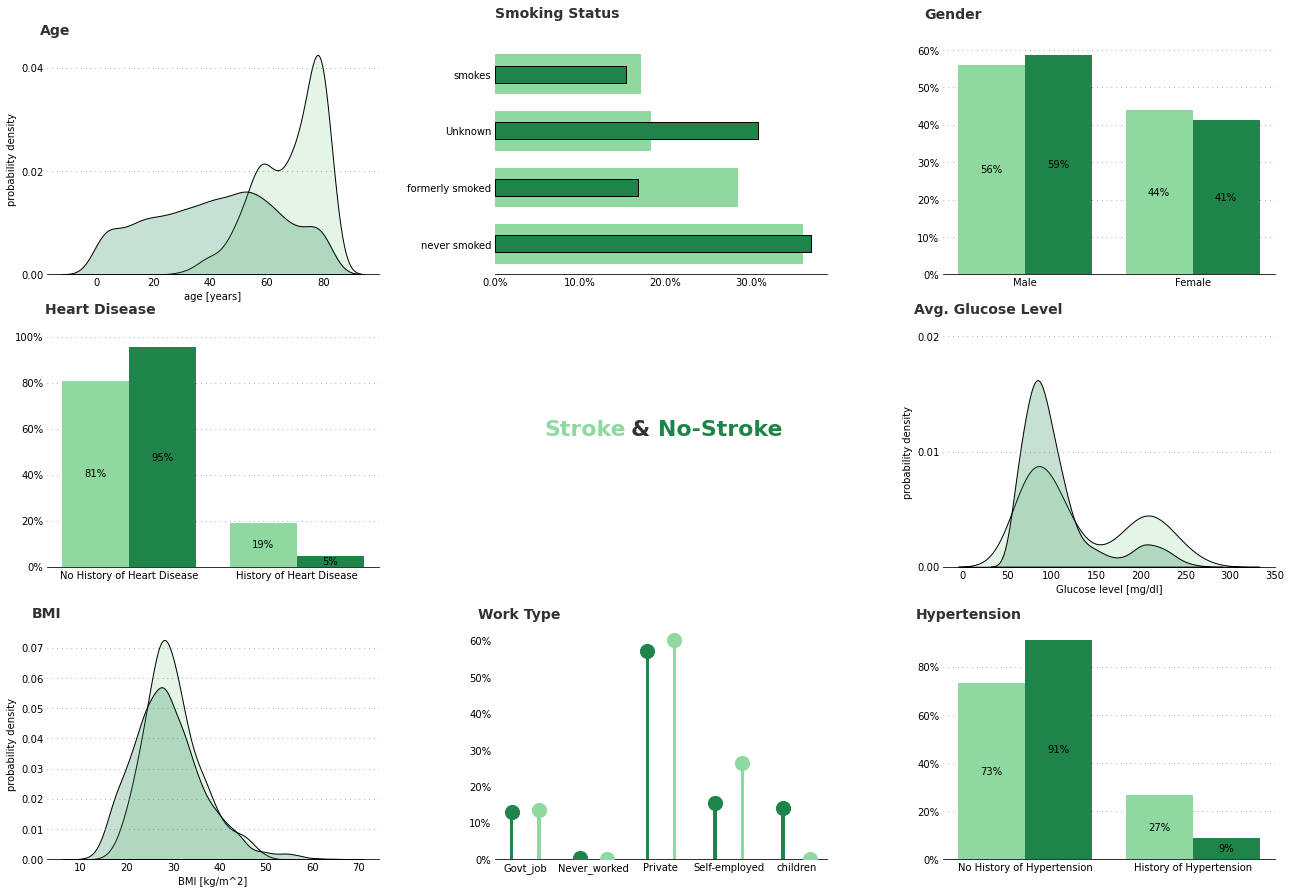

In [40]:
import matplotlib.ticker as mtick
str_only = df[df['stroke'] == 1]
no_str_only = df[df['stroke'] == 0]

fig = plt.figure(figsize=(22,15))
gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.35, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])
ax6 = fig.add_subplot(gs[2, 0])
ax7 = fig.add_subplot(gs[2, 1])
ax8 = fig.add_subplot(gs[2, 2])

background_color = 'white'
fig.patch.set_facecolor(background_color) # figure background color


# Plots

## Age


ax0.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
positive = pd.DataFrame(str_only["age"])
negative = pd.DataFrame(no_str_only["age"])
sns.kdeplot(positive["age"], ax=ax0,color="#8FD8A0", shade=True, ec='black',label="positive")
sns.kdeplot(negative["age"], ax=ax0, color="#1E8449", shade=True, ec='black',label="negative")
ax0.yaxis.set_major_locator(mtick.MultipleLocator(0.02))
#ax0.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax0.set_ylabel('probability density')    
ax0.set_xlabel('age [years]')
ax0.text(-20, 0.0465, 'Age', fontsize=14, fontweight='bold', color="#323232")



# Smoking
positive = pd.DataFrame(str_only["smoking_status"].value_counts())
positive["Percentage"] = positive["smoking_status"].apply(lambda x: x/sum(positive["smoking_status"])*100)
negative = pd.DataFrame(no_str_only["smoking_status"].value_counts())
negative["Percentage"] = negative["smoking_status"].apply(lambda x: x/sum(negative["smoking_status"])*100)

ax1.text(0, 4, 'Smoking Status', fontsize=14, fontweight='bold', color="#323232")
ax1.barh(positive.index, positive['Percentage'], color="#8FD8A0", zorder=3, height=0.7)
ax1.barh(negative.index, negative['Percentage'], color="#1E8449", zorder=3,ec='black', height=0.3)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter())
ax1.xaxis.set_major_locator(mtick.MultipleLocator(10))

##
# Ax2 - GENDER 
positive = pd.DataFrame(str_only["gender"].value_counts())
positive["Percentage"] = positive["gender"].apply(lambda x: x/sum(positive["gender"])*100)
negative = pd.DataFrame(no_str_only["gender"].value_counts())
negative["Percentage"] = negative["gender"].apply(lambda x: x/sum(negative["gender"])*100)

x = np.arange(len(positive))
ax2.text(-0.4, 68.5, 'Gender', fontsize=14, fontweight='bold', color="#323232")
ax2.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax2.bar(x, height=positive["Percentage"], zorder=3, color="#8FD8A0", width=0.4)
ax2.bar(x+0.4, height=negative["Percentage"], zorder=3, color="#1E8449", width=0.4)
ax2.set_xticks(x + 0.4 / 2)
ax2.set_xticklabels(['Male','Female'])
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.yaxis.set_major_locator(mtick.MultipleLocator(10))
for i,j in zip([0, 1], positive["Percentage"]):
    ax2.annotate(f'{j:0.0f}%',xy=(i, j/2), horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], negative["Percentage"]):
    ax2.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), horizontalalignment='center', verticalalignment='center')

    

# Heart Disease
positive = pd.DataFrame(str_only["heart_disease"].value_counts())
positive["Percentage"] = positive["heart_disease"].apply(lambda x: x/sum(positive["heart_disease"])*100)
negative = pd.DataFrame(no_str_only["heart_disease"].value_counts())
negative["Percentage"] = negative["heart_disease"].apply(lambda x: x/sum(negative["heart_disease"])*100)

x = np.arange(len(positive))
ax3.text(-0.3, 110, 'Heart Disease', fontsize=14, fontweight='bold',  color="#323232")
ax3.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax3.bar(x, height=positive["Percentage"], zorder=3, color="#8FD8A0", width=0.4)
ax3.bar(x+0.4, height=negative["Percentage"], zorder=3, color="#1E8449", width=0.4)
ax3.set_xticks(x + 0.4 / 2)
ax3.set_xticklabels(['No History of Heart Disease','History of Heart Disease'])
ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
ax3.yaxis.set_major_locator(mtick.MultipleLocator(20))
for i,j in zip([0, 1], positive["Percentage"]):
    ax3.annotate(f'{j:0.0f}%',xy=(i, j/2), horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], negative["Percentage"]):
    ax3.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), horizontalalignment='center', verticalalignment='center')
    

## Title
ax4.spines["bottom"].set_visible(False)
ax4.tick_params(left=False, bottom=False)
ax4.set_xticklabels([])
ax4.set_yticklabels([])

ax4.text(0.15,0.57,"Stroke", fontweight="bold",  fontsize=22, color='#8FD8A0')
ax4.text(0.41,0.57,"&", fontweight="bold", fontsize=22, color='#323232')
ax4.text(0.49,0.57,"No-Stroke", fontweight="bold", fontsize=22, color='#1E8449')


# Glucose level
ax5.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
positive = pd.DataFrame(str_only["avg_glucose_level"])
negative = pd.DataFrame(no_str_only["avg_glucose_level"])
sns.kdeplot(positive["avg_glucose_level"], ax=ax5,color="#8FD8A0",ec='black', shade=True, label="positive")
sns.kdeplot(negative["avg_glucose_level"], ax=ax5, color="#1E8449", ec='black',shade=True, label="negative")

# Set the y-axis tick positions
ax5.set_yticks([0, 0.01, 0.02])  
ax5.set_ylabel('probability density')  
ax5.set_xlabel('Glucose level [mg/dl]')
ax5.text(-55, 0.022, 'Avg. Glucose Level', fontsize=14, fontweight='bold', color="#323232")


# BMI
ax6.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
positive = pd.DataFrame(str_only["bmi"])
negative = pd.DataFrame(no_str_only["bmi"])
sns.kdeplot(positive["bmi"], ax=ax6,color="#8FD8A0", ec='black',shade=True, label="positive")
sns.kdeplot(negative["bmi"], ax=ax6, color="#1E8449",ec='black', shade=True, label="negative")
ax6.set_yticks([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07])  
ax6.set_ylabel('probability density') 
ax6.set_xlabel('BMI [kg/m^2]')
ax6.text(-0.5, 0.08, 'BMI', fontsize=14, fontweight='bold', color="#323232")


# Work Type
positive = pd.DataFrame(str_only["work_type"].value_counts())
positive["Percentage"] = positive["work_type"].apply(lambda x: x/sum(positive["work_type"])*100)
positive = positive.sort_index()

negative = pd.DataFrame(no_str_only["work_type"].value_counts())
negative["Percentage"] = negative["work_type"].apply(lambda x: x/sum(negative["work_type"])*100)
negative = negative.sort_index()

ax7.bar(negative.index, height=negative["Percentage"], zorder=3, color="#1E8449", width=0.05)
ax7.scatter(negative.index, negative["Percentage"], zorder=3,s=200, color="#1E8449")
ax7.bar(np.arange(len(positive.index))+0.4, height=positive["Percentage"], zorder=3, color="#8FD8A0", width=0.05)
ax7.scatter(np.arange(len(positive.index))+0.4, positive["Percentage"], zorder=3,s=200, color="#8FD8A0")

ax7.yaxis.set_major_formatter(mtick.PercentFormatter())
ax7.yaxis.set_major_locator(mtick.MultipleLocator(10))
ax7.set_xticks(np.arange(len(positive.index))+0.4 / 2)
ax7.set_xticklabels(list(positive.index),rotation=0)
ax7.text(-0.5, 66, 'Work Type', fontsize=14, fontweight='bold', color="#323232")



# Hypertension
positive = pd.DataFrame(str_only["hypertension"].value_counts())
positive["Percentage"] = positive["hypertension"].apply(lambda x: x/sum(positive["hypertension"])*100)
negative = pd.DataFrame(no_str_only["hypertension"].value_counts())
negative["Percentage"] = negative["hypertension"].apply(lambda x: x/sum(negative["hypertension"])*100)

x = np.arange(len(positive))
ax8.text(-0.45, 100, 'Hypertension', fontsize=14, fontweight='bold', color="#323232")
ax8.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax8.bar(x, height=positive["Percentage"], zorder=3, color="#8FD8A0", width=0.4)
ax8.bar(x+0.4, height=negative["Percentage"], zorder=3, color="#1E8449", width=0.4)
ax8.set_xticks(x + 0.4 / 2)
ax8.set_xticklabels(['No History of Hypertension','History of Hypertension'])
ax8.yaxis.set_major_formatter(mtick.PercentFormatter())
ax8.yaxis.set_major_locator(mtick.MultipleLocator(20))
for i,j in zip([0, 1], positive["Percentage"]):
    ax8.annotate(f'{j:0.0f}%',xy=(i, j/2), horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], negative["Percentage"]):
    ax8.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), horizontalalignment='center', verticalalignment='center')


for s in ["top","right","left"]:
    for i in range(0,9):
        locals()["ax"+str(i)].spines[s].set_visible(False)
        
for i in range(0,9):
        locals()["ax"+str(i)].set_facecolor(background_color)
        locals()["ax"+str(i)].tick_params(axis=u'both', which=u'both',length=0)
        locals()["ax"+str(i)].set_facecolor(background_color) 

        
plt.show()